In [1]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt 
import seaborn as sns
from surprise import Reader, Dataset, SVD, KNNBasic
from surprise.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from surprise.model_selection import train_test_split as ttsplit
import gcsfs
from surprise import accuracy
from sklearn.linear_model import Ridge

# Welcome to the Netflix recommender tutorial!

In this tutorial we are going to explore the Netflix dataset from the Netflix prize competition https://www.netflixprize.com/. This competition had $ 1 million dollars in prize money.

Recommendations are essential in Netflix, better recommendation improve the customer experience and improving these recommendations will eventually result in profits.

The dataset is very big, there are  initially it might look simple but there are quite some interesting aspects you have to take into account when creating an effective recommendation model. We have 480000 customers in the dataset and already 24 million ratings in just a segment of the dataset. 

As it is quite hard to work with the complete dataset we are going to work with a subset of 24M ratings in this tutorial, which is already a big dataset.

# Data loading

## Ratings

In [3]:
# Skip date
df = pd.read_csv('gs://codequarantine-tutorials/netflix/input/combined_data_1.txt', 
                  header = None, 
                  names = ['Cust_Id', 'Rating', 'date'], 
                  usecols = [0,1,2])

df['Rating'] = df['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Dataset 1 shape: (24058263, 3)
-Dataset examples-
          Cust_Id  Rating        date
0              1:     NaN         NaN
5000000   2560324     4.0  2005-12-06
10000000  2271935     2.0  2005-04-11
15000000  1921803     2.0  2005-01-31
20000000  1933327     3.0  2004-11-10


In [4]:
df_nan = df[df.Rating.isna()].copy()

In [5]:
df_nan['movie_id'] = df_nan['Cust_Id']

In [6]:
df.loc[df_nan.index, 'movie_id'] = df_nan['movie_id']

In [7]:
df.movie_id.ffill(inplace=True)

In [8]:
df.dropna(inplace=True)

In [9]:
df['movie_id'] = df.movie_id.str.replace(':', '')

In [10]:
df['movie_id'] = df.movie_id.astype(int)

In [11]:
np.random.seed(0)
sample = np.random.choice(df.movie_id.unique(), 2000)

In [12]:
df = df[df.movie_id.isin(sample)]

In [13]:
df['date'] = pd.to_datetime(df['date'])

In [14]:
df['month_year'] = df.date.dt.to_period('M')

In [15]:
df['weekday'] = df.date.dt.weekday

## Movie titles

We have a separate movie title dataset. The movie id's correspond to the movie id's in the rating dataset. 

In [16]:
df_titles = pd.read_csv('gs://codequarantine-tutorials/netflix/input/movie_titles.csv',
                        header=None,
                        usecols=[0,1,2],
                        names=['movie_id', 'year', 'title'],
                        encoding = "ISO-8859-1")

In [17]:
df_titles

movie_id    year                                              title
0             1  2003.0                                    Dinosaur Planet
1             2  2004.0                         Isle of Man TT 2004 Review
2             3  1997.0                                          Character
3             4  1994.0                       Paula Abdul's Get Up & Dance
4             5  2004.0                           The Rise and Fall of ECW
5             6  1997.0                                               Sick
6             7  1992.0                                              8 Man
7             8  2004.0                         What the #$*! Do We Know!?
8             9  1991.0                           Class of Nuke 'Em High 2
9            10  2001.0                                            Fighter
10           11  1999.0                     Full Frame: Documentary Shorts
11           12  1947.0                               My Favorite Brunette
12           13  2003.0  Lord of the Rings: The Return of the King: Ext...
13           14  1982.0                                 Nature: Antarctica
14           15  1988.0                   Neil Diamond: Greatest Hits Live
15           16  1996.0                                          Screamers
16           17  2005.0                                          7 Seconds
17           18  1994.0                                   Immortal Beloved
18           19  2000.0                              By Dawn's Early Light
19           20  1972.0                                    Seeta Aur Geeta
20           21  2002.0                                  Strange Relations
21           22  2000.0                                       Chump Change
22           23  2001.0  Clifford: Clifford Saves the Day! / Clifford's...
23           24  1981.0                                My Bloody Valentine
24           25  1997.0      Inspector Morse 31: Death Is Now My Neighbour
25           26  2004.0                                    Never Die Alone
26           27  1962.0  Sesame Street: Elmo's World: The Street We Liv...
27           28  2002.0                                    Lilo and Stitch
28           29  2001.0                                            Boycott
29           30  2003.0                             Something's Gotta Give
...         ...     ...                                                ...
17740     17741  2004.0                          Ginger Snaps 2: Unleashed
17741     17742  1995.0                                Catherine the Great
17742     17743  2003.0                               Better Luck Tomorrow
17743     17744  2004.0                         NASCAR: Tony Stewart Smoke
17744     17745  2002.0      Russell Simmons Presents Def Poetry: Season 1
17745     17746  1991.0  Godzilla & Mothra: Battle for Earth / Vs. King...
17746     17747  1991.0                            Eric Clapton: 24 Nights
17747     17748  2005.0        Dog the Bounty Hunter: The Best of Season 1
17748     17749  1985.0                                             No End
17749     17750  2005.0                     The Hee Haw Collection: Vol. 4
17750     17751  1993.0                               Highlander: Season 2
17751     17752  2003.0                                       Out of Order
17752     17753  1997.0                                       Maslin Beach
17753     17754  1999.0                                       On the Ropes
17754     17755  2003.0                           L/R: Licensed by Royalty
17755     17756  1935.0                                       The 39 Steps
17756     17757  2002.0  Ulysses S. Grant: Warrior / President: America...
17757     17758  1979.0                                           Prophecy
17758     17759  1972.0                                  The Big Bird Cage
17759     17760  2004.0                                      Lightning Bug
17760     17761  2003.0                                             Levity
17761     17762  1997.0         

# Data exploration

In [20]:
# Check structure of the dataset
df.head()

Cust_Id  Rating       date  movie_id month_year  weekday
1  1488844     3.0 2005-09-06         1    2005-09        1
2   822109     5.0 2005-05-13         1    2005-05        4
3   885013     4.0 2005-10-19         1    2005-10        2
4    30878     4.0 2005-12-26         1    2005-12        0
5   823519     3.0 2004-05-03         1    2004-05        0

In [21]:
df.tail()

Cust_Id  Rating       date  movie_id month_year  weekday
24057829  1184587     2.0 2004-11-02      4498    2004-11        1
24057830  2349702     3.0 2002-07-22      4498    2002-07        0
24057831  1174376     3.0 2005-03-03      4498    2005-03        3
24057832  1305108     3.0 2002-02-03      4498    2002-02        6
24057833  1766524     2.0 2004-05-04      4498    2004-05        1

In [23]:
# That's a lot of rows!
df.shape

(9347773, 6)

In [24]:
# Check number of unique users
df.Cust_Id.unique().shape

(450338,)

In [25]:
# Check number of unique movies
df.movie_id.unique().shape

(1599,)

In [26]:
# Check average rating, it's quite high 
df.Rating.mean()

3.640935012007673

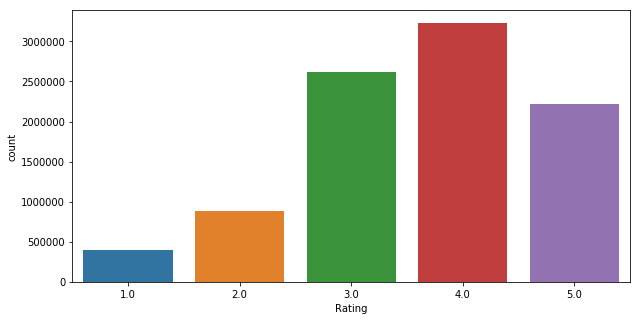

In [27]:
# Count individual ratings
plt.figure(figsize=(10,5))
sns.countplot('Rating', data=df)

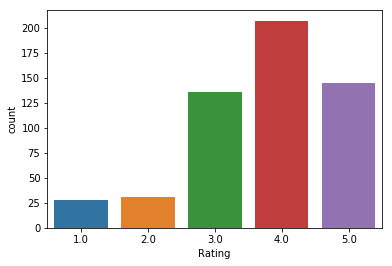

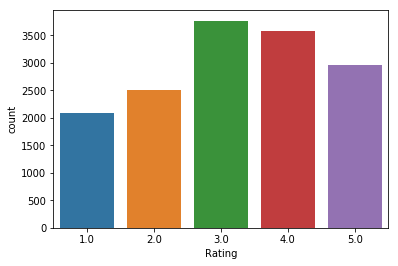

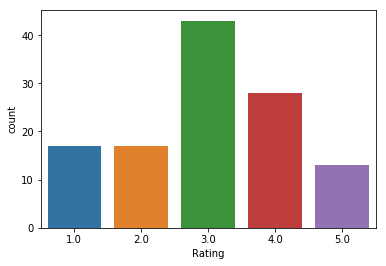

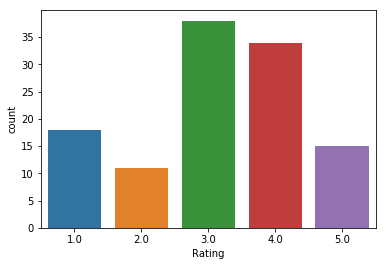

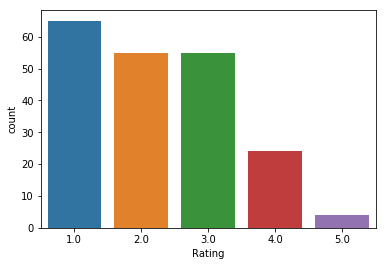

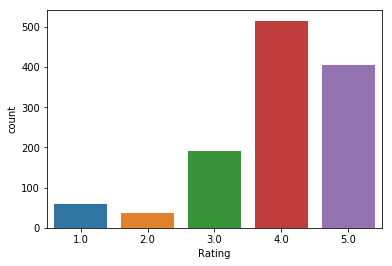

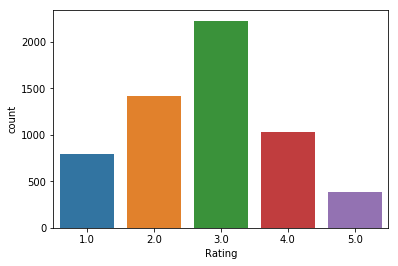

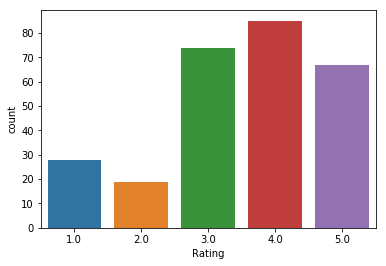

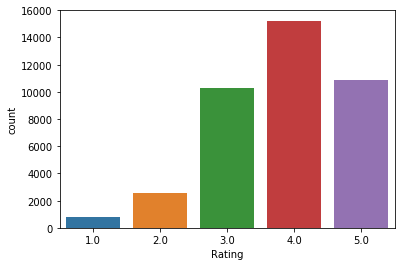

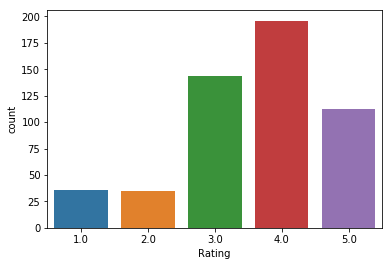

In [28]:
# Check ratings for some movies
for i in df.movie_id.unique()[0:10]:
    plt.figure()
    sns.countplot('Rating', data=df[df.movie_id == i])

### Are movies getting better?

In [29]:
# Group by date
grouped = df.groupby('date')

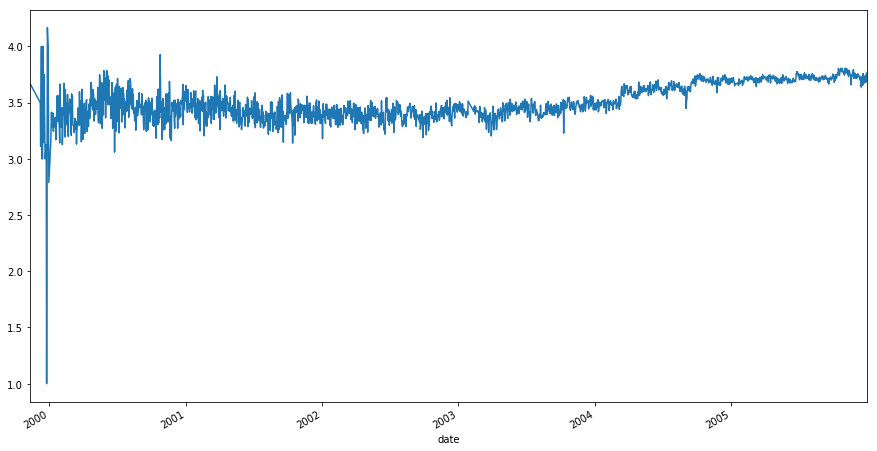

In [30]:
plt.figure(figsize=(15, 8))
grouped.Rating.mean().plot()

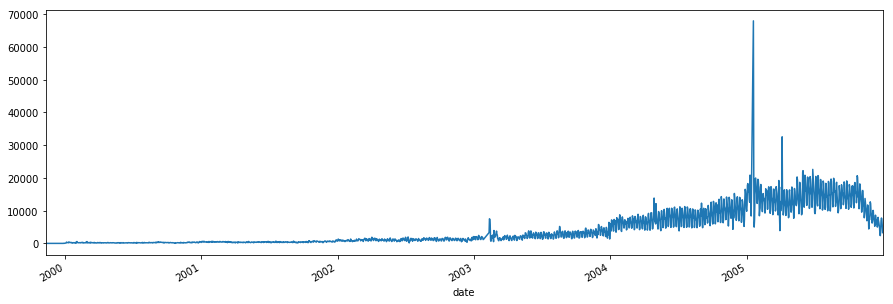

In [31]:
plt.figure(figsize=(15, 5))
grouped.Rating.count().plot()

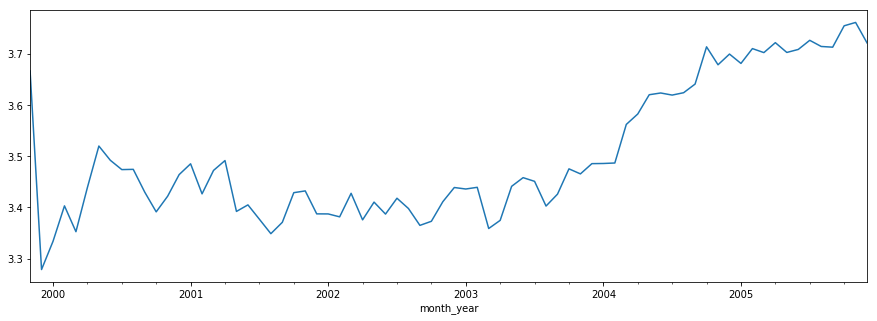

In [33]:
plt.figure(figsize=(15, 5))
df.groupby('month_year').Rating.mean().plot()

In [34]:
# Count number of ratings for each movie
counts = df.groupby(['movie_id']).Rating.count().reset_index()
counts.columns = ['movie_id', 'movie_rating_count']
df = pd.merge(df, counts, on='movie_id')

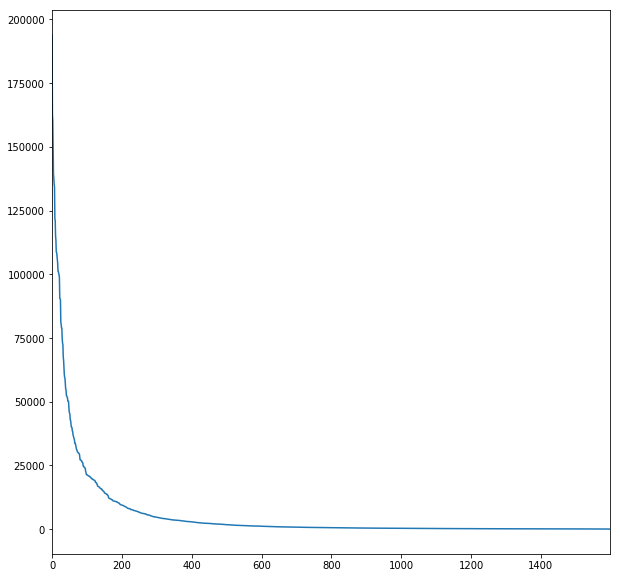

In [35]:
counts.sort_values('movie_rating_count', ascending=False).reset_index().movie_rating_count.plot(figsize=(10,10))

We can see that some movies are rated much much more then others

In [36]:
sub = df[df.movie_rating_count > 100]

In [37]:
# Rank movies by highest average rating, with at least 100 votes
ranked_movies = sub.groupby('movie_id').Rating.mean().sort_values(ascending=False).reset_index()
ranked_movies.columns = ['movie_id', 'avg_rating']

In [38]:
ranked_movies = pd.merge(ranked_movies, df_titles, on='movie_id')

In [39]:
ranked_movies

movie_id  avg_rating    year  \
0         3456    4.670989  2004.0   
1         2019    4.467500  2004.0   
2         2114    4.446714  2002.0   
3         1072    4.398458  2000.0   
4         2117    4.393701  2004.0   
5         1357    4.381994  2003.0   
6         2057    4.380080  2001.0   
7         1499    4.360746  2000.0   
8         2803    4.338748  1995.0   
9         4353    4.336022  2002.0   
10        2321    4.325879  2004.0   
11        4306    4.325245  1999.0   
12        4041    4.320598  2004.0   
13        4115    4.309862  1999.0   
14         316    4.301984  1999.0   
15        2548    4.299238  2000.0   
16        1409    4.289973  2003.0   
17        4207    4.286960  1980.0   
18        1441    4.279793  1998.0   
19        2942    4.273810  1999.0   
20        1230    4.248764  2005.0   
21        3115    4.248619  2001.0   
22        2861    4.239737  1996.0   
23        3864    4.236699  2005.0   
24         223    4.211192  2003.0   
25         325    4.195361  2004.0   
26        3079    4.195191  1994.0   
27        1017    4.192128  1955.0   
28         908    4.191339  1981.0   
29        1513    4.189868  1962.0   
...        ...         ...     ...   
1478      4023    2.064286  2003.0   
1479      3793    2.055556  2001.0   
1480       969    2.053030  1995.0   
1481      1519    2.049505  1981.0   
1482      3103    2.049180  1974.0   
1483       611    2.034247  2004.0   
1484      1614    2.028302  1997.0   
1485      4394    2.018504  2001.0   
1486      3219    2.014815  2000.0   
1487      1131    2.013699  1965.0   
1488      3361    2.007634  2002.0   
1489       592    2.000000  1974.0   
1490       975    2.000000  1997.0   
1491      2722    1.985507  2001.0   
1492      3021    1.962784  2003.0   
1493       151    1.954545  2005.0   
1494      3753    1.940299  2003.0   
1495      4039    1.933842  1974.0   
1496      2361    1.911392  2002.0   
1497      4469    1.851852  2002.0   
1498      2681    1.848214  2001.0   
1499      3459    1.816456  2000.0   
1500      3667    1.762584  1986.0   
1501      1924    1.759690  2002.0   
1502      3561    1.713514  2001.0   
1503        53    1.675439  2003.0   
1504      1725    1.522137  2003.0   
1505      1227    1.496241  2005.0   
1506      4202    1.487395  2004.0   
1507      3575    1.400000  2005.0   

                                                  title  
0                                        Lost: Season 1  
1                                      Samurai Champloo  
2                                               Firefly  
3                             As Time Goes By: Series 8  
4                                 Case Closed: Season 5  
5                               Stargate SG-1: Season 7  
6                    Buffy the Vampire Slayer: Season 6  
7                                                  FLCL  
8                                   Pride and Prejudice  
9                        Curb Your Enthusiasm: Season 3  
10                                          Get Backers  
11                                      The Sixth Sense  
12                              Mobile Suit Gundam SEED  
13                              The Simpsons: Bart Wars  
14        Futurama: Monster Robot Maniac Fun Collection  
15                              Gilmore Girls: Season 1  
16                                   The O.C.: Season 1  
17                     The Blues Brothers: Extended Cut  
18                              Stargate SG-1: Season 2  
19                                    Friends: Season 6  
20    Carlos Mencia: Not for the Easily Offended: Li...  
21                             Kabhi Khushi Kabhie Gham  
22                                  Babylon 5: Season 4  
23                                        Batman Begins  
24                           Chappelle's Show: Season 1  
25                          Ghosts of Rwanda: Frontline  
26                       The Lion King: Special Edition  
27                       

# Exercise: data exploration!

- Try to understand the exploratory data analysis I have made so far
- Try to visualize more aspects of the data

Hints:

- Does the day of the week matter?
- Do users rate different over time?

# Base model(s)

In [44]:
train, test = train_test_split(df, random_state=1)

In [45]:
def add_mean_all_movies(train, test):
    """
    Add a column with the average rating of all ratings
    """
    mean = train.Rating.mean()
    train['mean_rating_overall'] = mean
    test['mean_rating_overall'] = mean

In [46]:
def add_mean_specific_movie(train, test):
    """
    Add a column with the mean rating of a specific movie
    """
    means = train.groupby('movie_id').Rating.mean().reset_index()
    means.columns = ['movie_id', 'movie_rating_mean']
    train = pd.merge(train, means, on='movie_id')
    test = pd.merge(test, means, on='movie_id')
    return train, test

In [47]:
def add_customer_avg_rating(train, test):
    """
    Add column with average rating from a customer
    """
    grouped = train.groupby('Cust_Id').Rating.mean()
    grouped = grouped.reset_index()
    grouped.columns = ['Cust_Id', 'customer_avg_rating']
    train = pd.merge(train, grouped, on='Cust_Id')
    test = pd.merge(test, grouped, on='Cust_Id')
    return train, test

In [48]:
def create_features(df):
    train, test = train_test_split(df, random_state=1)
    train = train.copy()
    test = test.copy()
    add_mean_all_movies(train, test)
    train, test = add_mean_specific_movie(train, test)
    train, test = add_customer_avg_rating(train, test)
    return train, test
train, test = create_features(df)

In [49]:
del df

In [50]:
print(mse(train['Rating'], train['mean_rating_overall'], squared=False))
print(mse(test['Rating'], test['mean_rating_overall'], squared=False))

1.0702562727098566
1.0700970375322698


In [51]:
print(mse(train['Rating'], train['movie_rating_mean'], squared=False))
print(mse(test['Rating'], test['movie_rating_mean'], squared=False))

0.9994221195724
0.9997805954848855


In [52]:
print(mse(train['Rating'], train['customer_avg_rating'], squared=False))
print(mse(test['Rating'], test['customer_avg_rating'], squared=False))

0.9481614002907044
1.0163545735299226


In [53]:
train['pred'] = (train['movie_rating_mean'] + train['movie_rating_mean']) / 2
test['pred'] = (test['movie_rating_mean'] + test['movie_rating_mean']) / 2

In [54]:
print(mse(train['Rating'], train['pred'], squared=False))
print(mse(test['Rating'], test['pred'], squared=False))

0.9994221195724
0.9997805954848855


# Exercise: try to figure out more base models

Hints:

- Day of week mean model?
- Mean based on the current mean at time of rating?
- Other?


# Further preprocessing

In [55]:
optimization_var = 'Rating'
reader = Reader(rating_scale=(min(train[optimization_var]), max(train[optimization_var])))
traindata = Dataset.load_from_df(train[['Cust_Id', 'movie_id', optimization_var]][:], reader).build_full_trainset()
testdata = Dataset.load_from_df(test[['Cust_Id', 'movie_id',  optimization_var]][:], reader).build_full_trainset().build_testset()

# KNN Collaborative filtering - Item based

KNN collaborative filtering will determine the similarity between each item based on the users feedback. It will use the K nearest neighbours (most similar items) to predict the users preference. 

In [93]:
# Initialize KNN
algo = KNNBasic(k=15, verbose=True, sim_options={'user_based': False, 'name': 'pearson'})

In [94]:
# Fit model
algo.fit(traindata)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [95]:
# Make predictions and test root mean squared error on test set
predictions_test = algo.test(testdata)
accuracy.rmse(predictions_test)

RMSE: 0.9815


0.9814933054316691

In [96]:
# Calculate mean absolute error on test set
accuracy.mae(predictions_test)

MAE:  0.7687


0.7686700954984437

In [97]:
train

Cust_Id  Rating       date  movie_id month_year  weekday  \
0        1783158     3.0 2004-07-05       101    2004-07        0   
1        1783158     5.0 2005-07-13      2372    2005-07        2   
2        1783158     5.0 2004-05-14      1542    2004-05        4   
3        1783158     3.0 2004-06-25      4306    2004-06        4   
4        1783158     5.0 2004-05-19      1905    2004-05        2   
5        1783158     5.0 2004-10-05      2290    2004-10        1   
6        1783158     5.0 2004-05-14      1798    2004-05        4   
7        1783158     3.0 2004-05-14      3106    2004-05        4   
8        1783158     4.0 2005-08-19      1470    2005-08        4   
9        1783158     3.0 2005-11-08      3864    2005-11        1   
10       1783158     3.0 2004-06-28       257    2004-06        0   
11       1783158     4.0 2004-11-05      4330    2004-11        4   
12       1783158     3.0 2005-08-05      3624    2005-08        4   
13       1783158     2.0 2004-05-14      2200    2004-05        4   
14       1783158     4.0 2004-10-26       607    2004-10        1   
15       1783158     3.0 2004-10-26      2152    2004-10        1   
16       1783158     2.0 2005-03-09      3782    2005-03        2   
17       1783158     5.0 2004-05-20      1741    2004-05        3   
18       1783158     3.0 2005-11-27       831    2005-11        6   
19       1783158     5.0 2004-05-27      3079    2004-05        3   
20       1783158     2.0 2005-10-15      4041    2005-10        5   
21       1783158     3.0 2005-04-24      3138    2005-04        6   
22       1783158     4.0 2004-11-30      2252    2004-11        1   
23       1783158     3.0 2005-09-02      3239    2005-09        4   
24       1783158     1.0 2004-05-19      1902    2004-05        2   
25       1783158     4.0 2004-11-30      1467    2004-11        1   
26       1783158     5.0 2004-11-05      2803    2004-11        4   
27       1783158     5.0 2005-04-23      2019    2005-04        5   
28       1783158     3.0 2004-11-30      3960    2004-11        1   
29       1783158     4.0 2004-11-30       657    2004-11        1   
...          ...     ...        ...       ...        ...      ...   
7010799  1117541     3.0 2005-04-21      2419    2005-04        3   
7010800   648709     4.0 2004-11-21      1850    2004-11        6   
7010801  1469499     4.0 2005-02-07      1850    2005-02        0   
7010802  1580424     2.0 2005-11-03       770    2005-11        3   
7010803  2166485     5.0 2005-01-19       770    2005-01        2   
7010804   227732     5.0 2005-10-25       920    2005-10        1   
7010805   751624     2.0 2005-11-05       920    2005-11        5   
7010806   389986     5.0 2004-07-12      4076    2004-07        0   
7010807   293197     4.0 2005-07-25      3877    2005-07        0   
7010808  2596464     3.0 2005-12-12      3877    2005-12        0   
7010809  2078400     1.0 2002-10-30      1614    2002-10        2   
7010810  2002342     1.0 2005-01-27      2596    2005-01        3   
7010811   273989     4.0 2005-12-28      1685    2005-12        2   
7010812  2233771     3.0 2005-09-23       593    2005-09        4   
7010813  1236649     5.0 2005-08-07      2894    2005-08        6   
7010814   283107     5.0 2005-09-26      2894    2005-09        0   
7010815  2348587     5.0 2005-06-29      2894    2005-06        2   
7010816   850922     4.0 2004-05-06      4471    2004-05        3   
7010817   961251     2.0 2005-12-15      1410    2005-12        3   
7010818   741966     1.0 2004-11-22      1410    2004-11        0   
7010819   282715     3.0 2005-02-09      4436    2005-02        2   
7010820  2627898     3.0 2005-11-15      2367    2005-11        1   
7010821  2320613     4.0 2004-12-19      4205    2004-12        6   
7010822   821009     2.0 2005-05-23      4205    2005-05        0   
7010823   620932     5.0 2005-09-23      4205    2005-09        4   
7010824   297314     3.0 2005-06-27      3799    2005-06        0   
7010825

In [99]:
# Check movie id
df_titles.loc[df_titles['movie_id'] == 3456]['title'].values[0]

'Lost: Season 1'

In [100]:
def print_similar_movies(algo, movie_id, movie_titles, nr_recommendations):
    """
    Print similar movies based on the KNN model
    """
    recommendations = algo.get_neighbors(traindata.to_inner_iid(movie_id), nr_recommendations)
    for r in recommendations:
        rec_title = df_titles.loc[df_titles['movie_id'] == r]['title'].values[0]
        print(rec_title)

In [101]:
print_similar_movies(algo, 2117, df_titles, 10)

A Yank in the R.A.F.
Dragonheart
Sam the Iron Bridge
Dominion Tank Police Part 1 & 2
Spirit Lost
Where Sleeping Dogs Lie
Regular Guys
Missing in Action 2: The Beginning / Missing in Action 3: Braddock
Airplane II: The Sequel
Unconstitutional: The War on Our Civil Liberties


# Matrix Factorization

In [65]:
# Create classifier
algo = SVD(n_factors=10, n_epochs=5, verbose=True, random_state=123)

In [66]:
# Fit the model
algo.fit(traindata)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4


In [67]:
# Create validation predictions
predictions_test = algo.test(testdata)

In [68]:
# Calculate root mean squared error on validation data
accuracy.rmse(predictions_test)

RMSE: 0.9385


0.938527800564076

In [69]:
# Calculate mean absolute error on validation data
accuracy.mae(predictions_test)

MAE:  0.7380


0.7380216756270436

In [70]:
# Add test predictions to test dataset
preds = pd.DataFrame(predictions_test)[['uid', 'iid', 'est']]
del predictions_test
preds.columns = ['Cust_Id', 'movie_id', 'svd_preds']
test = pd.merge(test, preds, on=['Cust_Id', 'movie_id'])

In [71]:
# Add train predictions to train dataset
traindata_formatted = Dataset.load_from_df(train[['Cust_Id', 'movie_id', optimization_var]][:], reader).build_full_trainset().build_testset()

predictions_train = algo.test(traindata_formatted)
preds = pd.DataFrame(predictions_train)[['uid', 'iid', 'est']]
del predictions_train
preds.columns = ['Cust_Id', 'movie_id', 'svd_preds']
train = pd.merge(train, preds, on=['Cust_Id', 'movie_id'])
del traindata_formatted
del testdata

In [72]:
del algo

# Ensemble different models

In [73]:
# Select features for final model
features = ['mean_rating_overall', 'movie_rating_mean', 'customer_avg_rating', 'svd_preds']

In [74]:
# Create subset of dataframe
train_lin = train[['Rating'] + features]
test_lin = test[['Rating'] + features]

In [75]:
# split target from features
train_feats = train[features]
train_y = train.Rating

In [76]:
# Train a simple linear model
clf = LinearRegression().fit(train_feats, train_y)

In [77]:
# Predict test set
p = clf.predict(test_lin[features])

In [78]:
# Determine root mean squared error
mse(test['Rating'], p, squared=False)

0.9332745872341832

In [79]:
# Determine mean absolute error
mae(test['Rating'], p)

0.7325980933328218

In [80]:
# Check coefficients to see which features were most important
clf.coef_

array([0.01142729, 0.52675944, 0.62446058, 0.44670685])

# Exercise: Improve the model!

Ways to improve:

- Check out other recommendation models on surprise https://surprise.readthedocs.io/en/stable/index.html
- Tune the hyperparameters
- Add more models to the ensemble
- Add more features to the ensemble